In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np
import os
import zipfile
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.17.0


<a id = "dataprep"></a>
## Data preparation


In [8]:
# Unzip data
with zipfile.ZipFile("/content/drive/MyDrive/Lab1/dogs-vs-cats.zip","r") as z:
    z.extractall(".")

In [9]:
# Path and parameters
IMAGE_DIR = "/content/train"
H = 224
W = 224
epochs = 5
batch_size = 100
SEED = 42

In [23]:
# Unzip data
with zipfile.ZipFile("/content/train.zip","r") as z:
    z.extractall(".")

In [24]:
# Create dataframe
filenames = os.listdir(IMAGE_DIR)
labels = [x.split(".")[0] for x in filenames]
df = pd.DataFrame({"filename": filenames, "label": labels})
df.head()

,filename,label
0,dog.8359.jpg,dog
1,cat.5292.jpg,cat
2,dog.8762.jpg,dog
3,cat.4503.jpg,cat
4,dog.1961.jpg,dog


In [25]:
df.label.value_counts()

,count
label,
dog,12500
cat,12500


### Train - Test list

In [26]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state = SEED, stratify = df.label)
train_df.sample(frac=1, random_state=SEED)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [27]:
# Train data distribution
train_df.label.value_counts()

,count
label,
dog,10000
cat,10000


In [28]:
# Validation data distribution
val_df.label.value_counts()

,count
label,
dog,2500
cat,2500


<a id = "explore"></a>
# Data exploration


In [29]:
dogs = list(df[df.label=="dog"].filename)
cats = list(df[df.label=="cat"].filename)

In [30]:
# Adapted with serveral modifications from https://www.kaggle.com/serkanpeldek/keras-cnn-transfer-learnings-on-cats-dogs-dataset

def get_side(img, side_type, n = 5):
    h, w, c = img.shape
    if side_type == "horizontal":
        return np.ones((h,n,c))
    return np.ones((n,w,c))

def show_gallery(im_ls,n=5, shuffle=True):
    images = []
    vertical_images = []
    if shuffle:
        random.shuffle(im_ls)
    vertical_images = []
    for i in range(n*n):
        img = load_img(os.path.join(IMAGE_DIR,im_ls[i]), target_size=(W,H))
        img = img_to_array(img)
        hside = get_side(img,side_type="horizontal")
        images.append(img)
        images.append(hside)

        if (i+1) % n == 0:
            himage=np.hstack((images))
            vside = get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)

            images = []

    gallery = np.vstack((vertical_images))
    plt.figure(figsize=(20,20))
    plt.axis("off")
    plt.imshow(gallery.astype(np.uint8))
    plt.show()

In [31]:
# Show dogs images
show_gallery(dogs, n=10)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
# Show cat images
show_gallery(cats, n=10)

Output hidden; open in https://colab.research.google.com to view.

<a id = "gradcam"></a>
# GradCAM & GuidedGradCAM class defnition

<a id="gradcam1"></a>
## GradCAM


In [17]:
class GradCAM:
    def __init__(self, model, layerName=None):
        """
        model: pre-softmax layer (logit layer)
        """
        self.model = model
        self.layerName = layerName

        if self.layerName == None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")

    def compute_heatmap(self, image, classIdx, upsample_size, eps=1e-5):
        gradModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output, self.model.output]
        )
        # record operations for automatic differentiation

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOuts, preds) = gradModel(inputs) # preds after softmax
            loss = preds[:,classIdx]

        # compute gradients with automatic differentiation
        grads = tape.gradient(loss, convOuts)
        # discard batch
        convOuts = convOuts[0]
        grads = grads[0]
        norm_grads = tf.divide(grads, tf.reduce_mean(tf.square(grads)) + tf.constant(eps))

        # compute weights
        weights = tf.reduce_mean(norm_grads, axis=(0,1))
        cam = tf.reduce_sum(tf.multiply(weights, convOuts), axis=-1)

        # Apply reLU
        cam = np.maximum(cam, 0)
        cam = cam/np.max(cam)
        cam = cv2.resize(cam, upsample_size,interpolation=cv2.INTER_LINEAR)

        # convert to 3D
        cam3 = np.expand_dims(cam, axis=2)
        cam3 = np.tile(cam3, [1,1,3])

        return cam3

def overlay_gradCAM(img, cam3):
    cam3 = np.uint8(255*cam3)
    cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)

    new_img = 0.3*cam3 + 0.5*img

    return (new_img*255.0/new_img.max()).astype("uint8")

<a id = "gb"></a>
## GuidedBackprop


In [18]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

# Reference: https://github.com/eclique/keras-gradcam with adaption to tensorflow 2.0
class GuidedBackprop:
    def __init__(self,model, layerName=None):
        self.model = model
        self.layerName = layerName
        self.gbModel = self.build_guided_model()

        if self.layerName == None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply Guided Backpropagation")

    def build_guided_model(self):
        gbModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output]
        )
        layer_dict = [layer for layer in gbModel.layers[1:] if hasattr(layer,"activation")]
        for layer in layer_dict:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guidedRelu

        return gbModel

    def guided_backprop(self, images, upsample_size):
        """Guided Backpropagation method for visualizing input saliency."""
        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            tape.watch(inputs)
            outputs = self.gbModel(inputs)

        grads = tape.gradient(outputs, inputs)[0]

        saliency = cv2.resize(np.asarray(grads), upsample_size)

        return saliency

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

<a id="vis"></a>
## Visualization function


In [19]:
def show_gradCAMs(model, gradCAM, GuidedBP, im_ls, n=3, decode={}):
    """
    model: softmax layer
    """
    random.shuffle(im_ls)
    plt.subplots(figsize=(30, 10*n))
    k=1
    for i in range(n):
        img = cv2.imread(os.path.join(IMAGE_DIR,im_ls[i]))
        upsample_size = (img.shape[1],img.shape[0])
        if (i+1) == len(df):
            break
        # Show original image
        plt.subplot(n,3,k)
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.title("Filename: {}".format(im_ls[i]), fontsize=20)
        plt.axis("off")
        # Show overlayed grad
        plt.subplot(n,3,k+1)
        im = img_to_array(load_img(os.path.join(IMAGE_DIR,im_ls[i]), target_size=(W,H)))
        x = np.expand_dims(im, axis=0)
        x = preprocess_input(x)
        preds = model.predict(x)
        idx = preds.argmax()
        if len(decode)==0:
            res = decode_predictions(preds)[0][0][1:]
        else:
            res = [decode[idx],preds.max()]
        cam3 = gradCAM.compute_heatmap(image=x, classIdx=idx, upsample_size=upsample_size)
        new_img = overlay_gradCAM(img, cam3)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
        plt.imshow(new_img)
        plt.title("GradCAM - Pred: {}. Prob: {}".format(res[0],res[1]), fontsize=20)
        plt.axis("off")

        # Show guided GradCAM
        plt.subplot(n,3,k+2)
        gb = GuidedBP.guided_backprop(x, upsample_size)
        guided_gradcam = deprocess_image(gb*cam3)
        guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_BGR2RGB)
        plt.imshow(guided_gradcam)
        plt.title("Guided GradCAM", fontsize=20)
        plt.axis("off")

        k += 3
    plt.show()

<a id = "observe1"></a>
# Observe GradCAM with ResNet50 trained model on ImageNet


In [12]:
resnet50_logit = ResNet50V2(include_top=True, weights='imagenet', classifier_activation=None)

102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [13]:
resnet50_logit.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 25,613,800 (97.71 MB)

 Trainable params: 25,568,360 (97.54 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [14]:
resnet50 = ResNet50V2(include_top=True, weights='imagenet')

In [15]:
resnet50.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 25,613,800 (97.71 MB)

 Trainable params: 25,568,360 (97.54 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [36]:
gradCAM = GradCAM(model=resnet50_logit, layerName="conv5_block3_out")
guidedBP = GuidedBackprop(model=resnet50,layerName="conv5_block3_out")

In [34]:
show_gradCAMs(resnet50, gradCAM,guidedBP,dogs, n=5)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
show_gradCAMs(resnet50, gradCAM, guidedBP,cats, n=5)

Output hidden; open in https://colab.research.google.com to view.

In [37]:
gradCAM = GradCAM(model=resnet50_logit, layerName="conv3_block3_out")
guidedBP = GuidedBackprop(model=resnet50,layerName="conv3_block3_out")

In [38]:
show_gradCAMs(resnet50, gradCAM, guidedBP,cats, n=5)

Output hidden; open in https://colab.research.google.com to view.

In [39]:
gradCAM = GradCAM(model=resnet50_logit, layerName="conv2_block3_out")
guidedBP = GuidedBackprop(model=resnet50,layerName="conv2_block3_out")

In [40]:
show_gradCAMs(resnet50, gradCAM, guidedBP,cats, n=5)

Output hidden; open in https://colab.research.google.com to view.

<a id = "retrain1"></a>
# Re-train output layer of ResNet50 model on dogs and cats data

<a id="generator"></a>
## Data generator

In [ ]:
# Train generator
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_datagen.flow_from_dataframe(train_df, IMAGE_DIR,x_col="filename", y_col="label",
                                                    target_size=(W,H), class_mode="categorical",
                                                   batch_size=batch_size, shuffle=True, seed=SEED)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
# Validation generator
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
val_generator = val_datagen.flow_from_dataframe(val_df, IMAGE_DIR, x_col="filename", y_col="label",
                                               target_size=(W,H), class_mode="categorical",
                                                batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
# Look at how data generator augment the data
ex_df = train_df.sample(n=15).reset_index(drop=True)
ex_gen = train_datagen.flow_from_dataframe(ex_df,IMAGE_DIR,x_col="filename", y_col="label",
                                           target_size=(W,H), class_mode="categorical")

Found 15 validated image filenames belonging to 2 classes.


<a id = "model1"></a>
## Model

In [ ]:
resnet = ResNet50V2(include_top=False, pooling="avg", weights='imagenet')
for layer in resnet.layers:
    layer.trainable=False

logits = Dense(2)(resnet.layers[-1].output)
output = Activation('softmax')(logits)
model = Model(resnet.input, output)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


<a id = "compile1"></a>
## Compile

In [ ]:
sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer=sgd, loss = "categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


<a id = "train1"></a>
## Train

In [ ]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=20,
    steps_per_epoch=20,

)
model.save("/content/drive/MyDrive/trainedModel/resnet50_final.hdf5")

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 973ms/step - accuracy: 0.8537 - loss: 0.3650 - val_accuracy: 0.9805 - val_loss: 0.1014
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 701ms/step - accuracy: 0.9854 - loss: 0.0626 - val_accuracy: 0.9770 - val_loss: 0.0863
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9880 - loss: 0.0554

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 927ms/step - accuracy: 0.9879 - loss: 0.0562 - val_accuracy: 0.9840 - val_loss: 0.0800
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 895ms/step - accuracy: 0.9914 - loss: 0.0252 - val_accuracy: 0.9835 - val_loss: 0.0715
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 929ms/step - accuracy: 0.9939 - loss: 0.0225 - val_accuracy: 0.9845 - val_loss: 0.0552


In [ ]:
model.load_weights("/content/drive/MyDrive/trainedModel/resnet50_final.hdf5")

### Training metrics

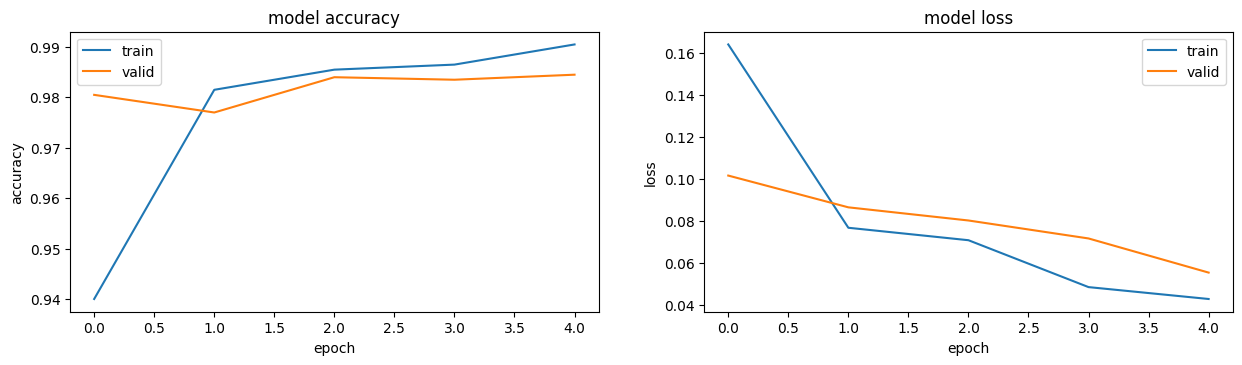

In [ ]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

<a id = "gradcam1"></a>
## Observe GradCAM with the re-trained model


In [ ]:
model_logit = Model(model.input,model.layers[-2].output)

In [ ]:
retrained_gradCAM = GradCAM(model=model_logit, layerName="conv5_block3_out")
retrained_guidedBP = GuidedBackprop(model=model, layerName="conv5_block3_out")

In [ ]:
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
test_generator = data_gen.flow_from_dataframe(val_df, IMAGE_DIR, x_col="filename",
                                               target_size=(W,H), class_mode=None,
                                                batch_size=1, shuffle=False)

Found 5000 validated image filenames.


In [ ]:
pred = model.predict(test_generator, steps = len(test_generator), verbose = 1)
pred_indices = np.argmax(pred,axis=1)

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step


In [ ]:
results = val_df.copy()
results["pred"] = pred_indices
true_dogs = list(results[(results.label == "dog") & (results.pred ==1)].filename)
true_cats = list(results[(results.label == "cat") & (results.pred ==0)].filename)
wrong_class = [x for x in results.filename if x not in (true_cats+true_dogs)]

### Dogs

In [ ]:
show_gradCAMs(model, retrained_gradCAM,retrained_guidedBP,true_dogs, n=5, decode={0:"cat", 1:"dog"})

### Cats

In [ ]:
show_gradCAMs(model, retrained_gradCAM,retrained_guidedBP,true_cats, n=5, decode={0:"cat", 1:"dog"})

### Wrong classes

In [ ]:
len(wrong_class)

83

In [ ]:
show_gradCAMs(model, retrained_gradCAM,retrained_guidedBP,wrong_class, n=5, decode={0:"cat", 1:"dog"})

<a id = "retrain2"></a>
# Add FC layers and train


<a id = "train2"></a>
## Training

In [ ]:
resnet = ResNet50V2(include_top=False, pooling="avg", weights='imagenet')
for layer in resnet.layers:
    layer.trainable=False

fc1 = Dense(100)(resnet.layers[-1].output)
fc2 = Dense(100)(fc1)
logits = Dense(2)(fc2)
output = Activation('softmax')(logits)
model_with_fc = Model(resnet.input, output)

In [ ]:
sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model_with_fc.compile(optimizer=sgd, loss = "categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history = model_with_fc.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    validation_steps=20,
    steps_per_epoch=20,
)
model_with_fc.save("/content/drive/MyDrive/trainedModel/resnet50fcbest.hdf5")

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 849ms/step - accuracy: 0.8188 - loss: 1.1601 - val_accuracy: 0.9705 - val_loss: 0.0882
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 569ms/step - accuracy: 0.9636 - loss: 0.0807 - val_accuracy: 0.9830 - val_loss: 0.0600
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9913 - loss: 0.0263

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9912 - loss: 0.0266 - val_accuracy: 0.9840 - val_loss: 0.0443
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 775ms/step - accuracy: 0.9897 - loss: 0.0326 - val_accuracy: 0.9840 - val_loss: 0.0499
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 649ms/step - accuracy: 0.9874 - loss: 0.0407 - val_accuracy: 0.9855 - val_loss: 0.0429


In [ ]:
model_with_fc.load_weights("/content/drive/MyDrive/trainedModel/resnet50fcbest.hdf5")

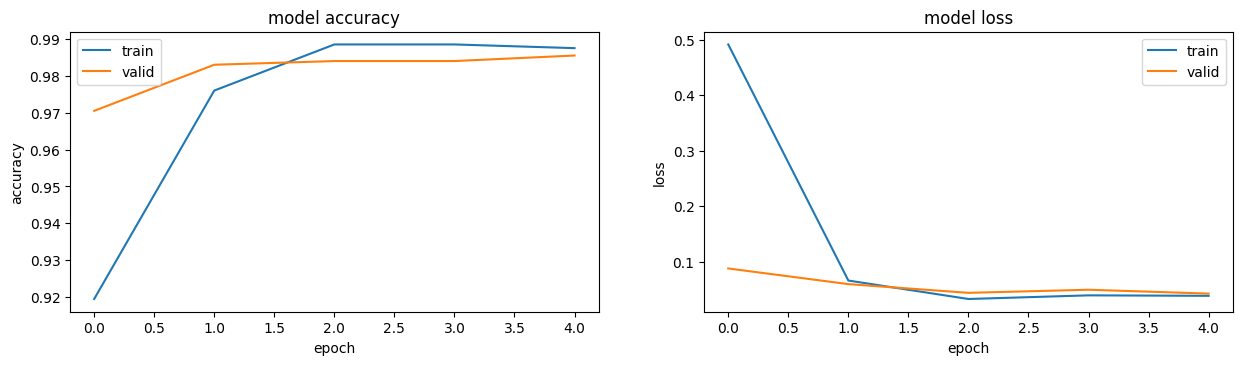

In [ ]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

<a id = "gradcam2"></a>
## Observe GradCAM


In [ ]:
model_fc_logit = Model(model_with_fc.input,model_with_fc.layers[-2].output)
fctrained_gradCAM = GradCAM(model=model_fc_logit, layerName="conv5_block3_out")
fctrained_guidedBP = GuidedBackprop(model=model_with_fc, layerName="conv5_block3_out")

In [ ]:
test_generator = data_gen.flow_from_dataframe(val_df, IMAGE_DIR, x_col="filename",
                                               target_size=(W,H), class_mode=None,
                                                batch_size=1, shuffle=False)
pred = model_with_fc.predict(test_generator, steps = len(test_generator), verbose = 1)
pred_indices = np.argmax(pred,axis=1)

Found 5000 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step


In [ ]:
results = val_df.copy()
results["pred"] = pred_indices
true_dogs = list(results[(results.label == "dog") & (results.pred ==1)].filename)
true_cats = list(results[(results.label == "cat") & (results.pred ==0)].filename)
wrong_class = [x for x in results.filename if x not in (true_cats+true_dogs)]

### Dogs

In [ ]:
show_gradCAMs(model_with_fc, fctrained_gradCAM, fctrained_guidedBP,true_dogs, n=5, decode={0:"cat", 1:"dog"})

### Cats

In [ ]:
show_gradCAMs(model_with_fc, fctrained_gradCAM, fctrained_guidedBP, true_cats, n=5, decode={0:"cat", 1:"dog"})

### Wrong classes

In [ ]:
len(wrong_class)

78

In [ ]:
show_gradCAMs(model_with_fc, fctrained_gradCAM, fctrained_guidedBP, wrong_class, n=5, decode={0:"cat", 1:"dog"})

In [ ]:
# Setup for Colab
import sys
from pathlib import Path
IN_COLAB = 'google.colab' in sys.modules

srcpath = Path("src")

if IN_COLAB and not srcpath.exists(): # if running in Colab --> download src if not exists
    !git clone https://github.com/hnguyentt/GradCAM_and_GuidedGradCAM_tf2
    !mv GradCAM_and_GuidedGradCAM_tf2/assets .
    !mv GradCAM_and_GuidedGradCAM_tf2/src .

Cloning into 'GradCAM_and_GuidedGradCAM_tf2'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 127 (delta 2), reused 6 (delta 2), pack-reused 120
Receiving objects: 100% (127/127), 119.19 MiB | 29.37 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Updating files: 100% (23/23), done.


In [ ]:
#@title Click on the Run button to run
from IPython.display import display, Javascript, HTML, clear_output, IFrame
from ipywidgets import interact, interactive, fixed, interact_manual, AppLayout, GridspecLayout
import ipywidgets as widgets
from src.gradcam import GradCAM, overlay_gradCAM
from src.guidedBackprop import GuidedBackprop, deprocess_image
from src.utils import preprocess, predict, SAMPLE_DIR, array2bytes, DECODE, INV_MAP
from src.models import load_ResNet50PlusFC, load_VanilaResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os, cv2
import matplotlib.pyplot as plt

# Header
header = widgets.HTML('<font color="#1f77b4" face="sans-serif"><center><h1>DEMO GradCAM and Guided GradCAM</h1></center></font>',
                      layout=widgets.Layout(height='auto'))

# Dropdowns
def on_change_im(change):
    if change['type'] == "change" and change["name"] == "value":
        img = cv2.imread(os.path.join(SAMPLE_DIR,change["new"]))
        im_arr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        grid[5:13, 1:9] = widgets.HTML("")

def on_change_model(change):
    if change['type'] == "change" and change["name"] == "value":
        chosen_model =  widgets.HTML("<center><p>Model %s loaded.<center>" % change["new"])
        grid[2,:8] = chosen_model

im_ls = ["--Select"] + [x for x in os.listdir("./assets/samples") if not x.startswith(".")]
im_ls.sort()
model_ls = ["--Select","VanilaResNet50", "ResNet50PlusFC"]
class_ls = ["--Select","Cat", "Dog"]
models = widgets.Dropdown(options=model_ls, description="Model",layout={'width':'auto'}, disabled=False)
imgs = widgets.Dropdown(options=im_ls, description="Image", layout={'width':'auto'}, disabled=False)
classes = widgets.Dropdown(options=class_ls, description="Class", layout={'width':'auto'}, disabled=False)
imgs.observe(on_change_im)
models.observe(on_change_model)
# Notes
# note = widgets.HTML("<p><b>Modes:</b><br>- VanilaResNet50 is retrained ResNet50 model on Dog vs. Cat dataset<br>"
#                     "- ResNet50PlusFC is the model with 2 FC layers added to ResNet50, retrained on Dog vs. Cat dataset"
#                     "<br><b>Classes: </b>If not specified, GradCAM & Guided GradCAM will be calculated based on the predicted class</p>")

# button
def create_expanded_button(description, button_style):
    return widgets.Button(description=description, button_style=button_style,
                          layout=widgets.Layout(height='auto', width='auto'))
pred_but = create_expanded_button("Show","info")

# Layouts
grid = GridspecLayout(20, 30, height='700px')
grid[0,:] = header
grid[1,:8] = models
grid[1,8:17] = imgs
grid[1,17:24] = classes
grid[1,25:] = pred_but
# grid[17:,:] = note
display(grid)

def showCAMs(img, x, GradCAM, GuidedBP, chosen_class, upsample_size):
    cam3 = GradCAM.compute_heatmap(image=x, classIdx=chosen_class, upsample_size=upsample_size)
    gradcam = overlay_gradCAM(img, cam3)
    gradcam = cv2.cvtColor(gradcam, cv2.COLOR_BGR2RGB)
    # Guided backprop
    gb = GuidedBP.guided_backprop(x, upsample_size)
    gb_im = deprocess_image(gb)
    gb_im = cv2.cvtColor(gb_im, cv2.COLOR_BGR2RGB)
    # Guided GradCAM
    guided_gradcam = deprocess_image(gb*cam3)
    guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_BGR2RGB)

    # Display
    gc = widgets.Image(
            value=array2bytes(gradcam),
            format='png',
            width='auto',
            height='auto',
            align="center-align"
        )
    gbim = widgets.Image(
            value=array2bytes(gb_im),
            format='png',
            width='auto',
            height='auto',
            align="center-align"
        )
    ggc = widgets.Image(
            value=array2bytes(guided_gradcam),
            format='png',
            width='auto',
            height='auto',
            align="center-align"
        )
    grid[4, 1:9] = widgets.HTML('<center><b>GradCAM</b></center>')
    grid[4, 11:19] = widgets.HTML('<center><b>Guided Bacpropagation</b></center>')
    grid[4, 21:29] = widgets.HTML('<center><b>Guided GradCAM</b></center>')
    grid[5:13, 1:9] = gc
    grid[5:13, 11:19] = gbim
    grid[5:13, 21:29] = ggc

def check_button(sender):
#     if models.value == "VanilaResNet50"
    if models.value == "VanilaResNet50":
        model = load_VanilaResNet50()
        gradCAM = GradCAM(model=model, layerName="conv5_block3_out")
        guidedBP = GuidedBackprop(model=model,layerName="conv5_block3_out")
    elif models.value == "ResNet50PlusFC":
        model = load_ResNet50PlusFC()
        gradCAM = GradCAM(model=model, layerName="conv5_block3_out")
        guidedBP = GuidedBackprop(model=model, layerName="conv5_block3_out")
#     img = img_to_array(load_img(os.path.join(SAMPLE_DIR,imgs.value), target_size=(224,224)))
    img = cv2.imread(os.path.join(SAMPLE_DIR,imgs.value))
    upsample_size = (img.shape[1],img.shape[0])
    x = preprocess(imgs.value)
    pred, prob = predict(model,x)
    if classes.value == "--Select":
        classIdx = pred
    else:
        classIdx = INV_MAP[classes.value]

    grid[2,9:18] = widgets.HTML("<center><span>Predicted: <b>{}<b><span><center>".format(DECODE[pred]))

    showCAMs(img, x, gradCAM, guidedBP, classIdx, upsample_size)

pred_but.on_click(check_button)

GridspecLayout(children=(HTML(value='<font color="#1f77b4" face="sans-serif"><center><h1>DEMO GradCAM and Guid…

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
